In [1]:
# %load_ext autoreload
# %autoreload 2

import inspect
import networkx as nx
import typedb
import azlib.queries as azq
import matplotlib.pyplot as plt

from typedb.client import *
from kglib.utils.graph.query.query_graph import QueryGraphAZ
from kglib.utils.graph.thing.queries_to_networkx_graph import build_graph_from_queries
from typing import List, Dict

DATABASE = "orbit"
ADDRESS = "localhost:1729"

client = TypeDB.core_client(ADDRESS)
session = client.session(DATABASE, SessionType.DATA)

In [131]:
def create_concept_graphs(
                example_names: Dict, 
                typedb_session: typedb.connection.session, 
                infer: bool = True) -> List: 
    """
    Builds an in-memory graph for each example, with an example_id as an anchor for each example subgraph.
    Args:
        example_names: The names used to anchor the subgraph queries within the entire knowledge graph
        typedb_session: TypeDB Session

    Returns:
        In-memory graphs of TypeDB subgraphs
    """

    graphs = []

    options = TypeDBOptions.core()
    options.infer = infer

    for subgraph_type, ingredient_names in example_names.items():
        for name in ingredient_names:
            print(f'Creating graph for example {name}')
            graph_query_handles = get_query_handles(name, subgraph_type)

            if len(graph_query_handles) > 0:
                with typedb_session.transaction(TransactionType.READ, options) as tx:
                    # build a graph from the queries, samplers, and query graphs
                    graph = build_graph_from_queries(graph_query_handles, tx)

                #NOTE: not required for zess-acd-cocktail a our learning is unsupervised
                # obfuscate_labels(graph, TYPES_AND_ROLES_TO_OBFUSCATE)

                graph.name = name
                graphs.append(graph)

    return graphs


def get_query_handles(
            ingredient_name: str, 
            subgraph_type: str) -> List[tuple]:
    """
    Creates an iterable, each element containing a Graql query, a function to sample the answers, and a QueryGraph
    object which must be the TypeDB graph representation of the query. This tuple is termed a "query_handle".

    Args:
        example_id: A uniquely identifiable attribute value used to anchor the results of the queries to a 
                    specific subgraph

    Returns:
        query handles
    """
    if subgraph_type == 'cnc':
        q = azq.METAPATH_CNC.format(name=ingredient_name)
        query = inspect.cleandoc(q)
        vars = n, c1, c2, uw1, uw2 = 'n', 'c1', 'c2', 'uw1', 'uw2'
        graph = (QueryGraphAZ().add_vars(vars)
                               .add_role_edge(uw1, c1, 'ingredient-a-used-with')
                               .add_role_edge(uw1, n, 'ingredient-b-used-with')
                               .add_role_edge(uw2, n, 'ingredient-a-used-with')
                               .add_role_edge(uw2, c2, 'ingredient-a-used-with'))

    elif subgraph_type == 'ncfcn':
        q = azq.METAPATH_NCFCN.format(name=ingredient_name)
        query = inspect.cleandoc(q)
        vars = f, c1, c2, n1, n2, uw1, bt1, bt2, uw2 \
             = 'f', 'c1', 'c2', 'n1', 'n2', 'uw1', 'bt1', 'bt2', 'uw2';
        graph = (QueryGraphAZ().add_vars(vars)
                               .add_role_edge(uw1, n1, 'ingredient-a-used-with')
                               .add_role_edge(uw1, c1, 'ingredient-b-used-with')
                               .add_role_edge(bt1, c1, 'compound-ingredient-bound-to')
                               .add_role_edge(bt1, f, 'flavor-compound-bound-to')
                               .add_role_edge(bt2, f, 'flavor-compound-bound-to')
                               .add_role_edge(bt2, c2, 'compound-ingredient-bound-to')
                               .add_role_edge(uw2, c2, 'ingredient-a-used-with')
                               .add_role_edge(uw2, n2, 'ingredient-b-used-with'))
                               
    elif subgraph_type == 'fcncf':
        q = azq.METAPATH_FCNCF.format(name=ingredient_name)
        query = inspect.cleandoc(q)
        vars =  n, f1, f2, c1, c2, bt1, uw1, uw2, bt2 \
             = 'n', 'f1', 'f2', 'c1', 'c2', 'bt1', 'uw1', 'uw2', 'bt2'
        graph = (QueryGraphAZ().add_vars(vars)
                                .add_role_edge(bt1, f1, 'flavor-compound-bound-to')
                                .add_role_edge(bt1, c1, 'compound-ingredient-bound-to')
                                .add_role_edge(uw1, c1, 'ingredient-a-used-with')
                                .add_role_edge(uw1, n, 'ingredient-b-used-with')
                                .add_role_edge(uw2, n, 'ingredient-a-used-with')
                                .add_role_edge(uw2, c2, 'ingredient-b-used-with')
                                .add_role_edge(bt2, c2, 'compound-ingredient-bound-to')
                                .add_role_edge(bt2, f2, 'flavor-compound-bound-to'))
    else:
        return []    

    return [
        (query, lambda x: x, graph)
    ]



Creating graph for example olive brine
working on query: match 
    # entities
    $n isa non-compound-ingredient, has name 'olive brine';
    $f1 isa flavor-compound;
    $f2 isa flavor-compound;
    $c1 isa compound-ingredient;
    $c2 isa compound-ingredient;

    # relations
    $bt1 (flavor-compound-bound-to: $f1, compound-ingredient-bound-to: $c1) isa bound-to;
    $uw1 (ingredient-a-used-with: $c1, ingredient-b-used-with: $n) isa used-with;
    $uw2 (ingredient-a-used-with: $n, ingredient-b-used-with: $c2) isa used-with;
    $bt2 (compound-ingredient-bound-to: $c2, flavor-compound-bound-to: $f2) isa bound-to;
get 
    $n, $f1, $f2, $c1, $c2, $bt1, $uw1, $uw2, $bt2;
    offset 0; limit 1;
query completed
constructed concept_dicts
Creating graph for example grenadine
working on query: match 
    # entities
    $n isa non-compound-ingredient, has name 'grenadine';
    $f1 isa flavor-compound;
    $f2 isa flavor-compound;
    $c1 isa compound-ingredient;
    $c2 isa compound-ingredi

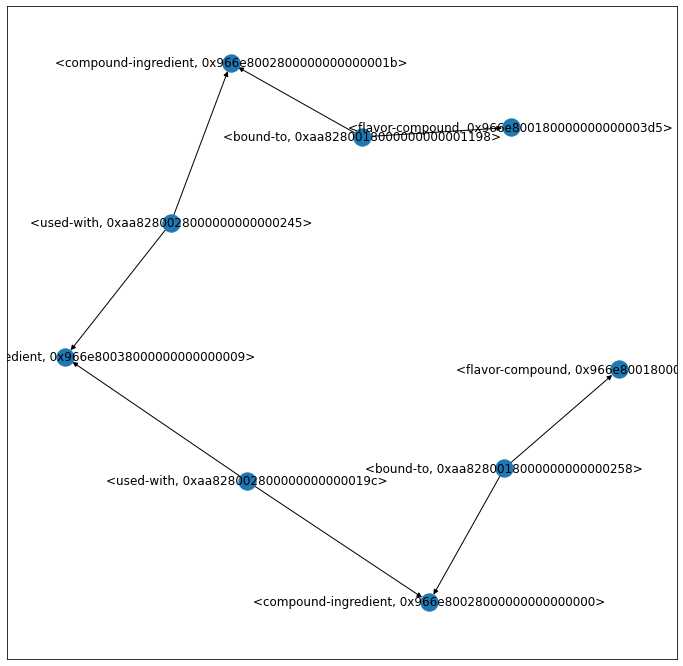

In [133]:
example_names = {
    # F - C - N - C' - F'; enter N names
    'fcncf': ['olive brine', 'grenadine'], 
    
    # N - C - F - C' - N'; enter F names
    'ncfcn': ['alpha-maltose', 'alpha-maltose'], 
    
    # C - N - C'; enter N names; this is just for testing
    'cnc': ['olive brine', 'sugar'],
}
graphs = create_concept_graphs(example_names, session)

# plot one single graph
g = graphs[0]
print('\n')
print(g.graph)
print('*'*100)
print('Nodes:')
print(g.nodes)
print('\nEdges:')
print(g.edges)
plt.figure(figsize=(12,12)) 
nx.draw_networkx(g, with_labels=True)
pass

In [4]:
import pickle
import typedb

In [5]:
with open(
    "/Users/kostaspsychogyio/Desktop/zess-acd/metapath_extraction/data/graphs.pkl",
    "rb",
) as f:
    graphs = pickle.load(f)


Nodes:


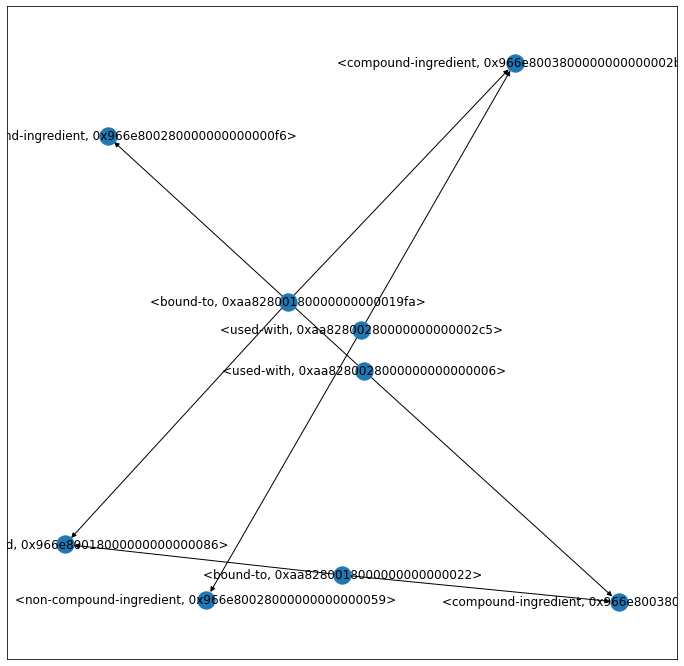

In [19]:
nodes = []
for g in graphs:
    print('Nodes:')
    nodes.append(g.nodes)
    plt.figure(figsize=(12,12)) 
    nx.draw_networkx(g, with_labels=True)
    break

In [29]:
df = nx.to_pandas_edgelist(graphs[0])
df.to_csv('ttt.csv')

In [40]:
print(graphs[0])

celery salt


In [108]:
print((nodes[0]))

[<bound-to, 0xaa8280018000000000000022>, <compound-ingredient, 0x966e80038000000000000004>, <used-with, 0xaa82800280000000000002c5>, <non-compound-ingredient, 0x966e80028000000000000059>, <flavor-compound, 0x966e80018000000000000086>, <compound-ingredient, 0x966e8003800000000000002b>, <bound-to, 0xaa82800180000000000019fa>, <non-compound-ingredient, 0x966e800280000000000000f6>, <used-with, 0xaa8280028000000000000006>]


In [106]:
from gensim.models import Word2Vec

model = Word2Vec(nodes, window=5, min_count=0, sg=1, workers=2)

In [107]:
model.wv.vectors.shape

(1186, 100)

In [99]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = (
    model.wv.vectors
)

In [100]:
from sklearn.manifold import TSNE
transform = TSNE  # PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

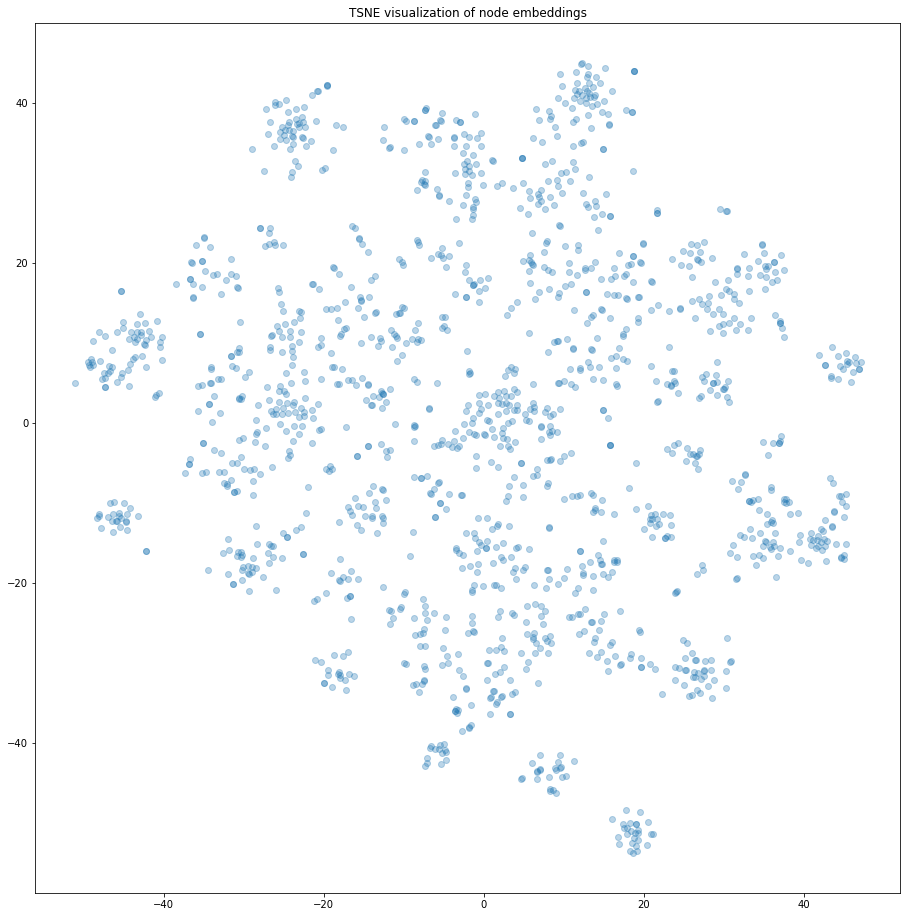

In [101]:
import numpy as np
plt.figure(figsize=(20, 16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], alpha=0.3)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()